# Оценка метрик RAG эндпоинта

Этот ноутбук предназначен для проверки основных метрик RAG (Retrieval Augmented Generation) эндпоинта.

**Параметры запроса:**
- `use_hyde`: True (используем HyDE для улучшения качества поиска)
- `temperature`: 0.4 (контролирует случайность генерации)
- `top_k`: 5 (количество релевантных документов)

**Эндпоинт:** `http://localhost:8000/rag`


In [3]:
import requests
import json
import pandas as pd
import numpy as np
from typing import List, Dict, Any
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import nltk
import os
from openai import OpenAI
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock
from dotenv import load_dotenv


load_dotenv()

# Скачиваем необходимые данные для NLTK (если еще не скачаны)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

sns.set_style('whitegrid')
%matplotlib inline

# Инициализация OpenAI клиента для дополнительных метрик
openai_client = OpenAI(
    api_key=os.getenv('OPENAI_API_KEY'),
    base_url=os.getenv('OPENAI_API_BASE')
)
embedding_model = os.getenv('OPENAI_EMBEDDING_MODEL_NAME', 'text-embedding-3-large')
chat_model = os.getenv('OPENAI_CHAT_MODEL_NAME', 'gpt-4o-mini')


## 1. Загрузка датасета вопросов


In [4]:
# Загружаем датасет с вопросами
dataset_path = '/home/llm-dev/project/lifelong_learning_assistant/data/dataset.jsonl'

questions_data = []
with open(dataset_path, 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():
            questions_data.append(json.loads(line))


## 2. Функция для запроса к RAG эндпоинту


In [5]:
def query_rag_endpoint(
    query: str,
    temperature: float = 0.4,
    top_k: int = 5,
    use_hyde: bool = True,
    endpoint_url: str = 'http://localhost:8000/rag'
) -> Dict[str, Any]:
    """
    Отправляет запрос к RAG эндпоинту.
    
    Args:
        query: Вопрос для RAG
        temperature: Температура генерации (0.0-1.0)
        top_k: Количество релевантных документов
        use_hyde: Использовать ли HyDE
        endpoint_url: URL эндпоинта
    
    Returns:
        Ответ от эндпоинта в виде словаря
    """
    payload = {
        "query": query,
        "temperature": temperature,
        "top_k": top_k,
        "use_hyde": use_hyde
    }
    
    try:
        response = requests.post(endpoint_url, json=payload, timeout=None)  # Убираем таймаут
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе: {e}")
        return None


## 3. Тестовый запрос


In [6]:
# Проверяем работу эндпоинта на одном примере
test_query = "Что такое байесовский подход в машинном обучении?"
test_response = query_rag_endpoint(test_query)

if test_response:
    print("✅ Эндпоинт работает!\n")
    print(f"Вопрос: {test_response.get('query', 'N/A')}")
    print(f"\nОтвет: {test_response.get('answer', 'N/A')}")
    print(f"\nИспользован HyDE: {test_response.get('used_hyde', False)}")
    print(f"Количество использованных документов: {test_response.get('num_documents_used', 0)}")
    print(f"Всего токенов в контексте: {test_response.get('total_tokens_context', 0)}")
    print(f"\nНайдено документов: {len(test_response.get('documents', []))}")
    
    if test_response.get('documents'):
        print("\nТоп-3 документа по релевантности:")
        for i, doc in enumerate(test_response['documents'][:3], 1):
            print(f"\n{i}. Score: {doc.get('score', 0):.4f}")
            print(f"   Файл: {doc.get('metadata', {}).get('filename', 'N/A')}")
            print(f"   Токенов: {doc.get('tokens', 0)}")
            print(f"   Контент (первые 150 символов): {doc.get('content', '')[:150]}...")
else:
    print("❌ Ошибка: эндпоинт недоступен. Убедитесь, что сервер запущен на localhost:8000")


✅ Эндпоинт работает!

Вопрос: Что такое байесовский подход в машинном обучении?

Ответ: Байесовский подход в машинном обучении основывается на использовании теоремы Байеса для обновления априорных представлений о распределении параметров модели на основе наблюдаемых данных. Вот основные характеристики этого подхода:

### Основные принципы
1. **Априорное распределение**:
   - Перед появлением данных у нас есть некоторое априорное представление о распределении параметров модели (например, весов). Это распределение не зависит от данных.

2. **Обновление с помощью данных**:
   - После получения данных мы используем их для уточнения нашего понимания распределения параметров, формируя апостериорное распределение. Это делается с помощью формулы Байеса:
   \[
   P(\theta | D) = \frac{P(D | \theta) P(\theta)}{P(D)}
   \]
   где:
   - \(P(\theta | D)\) — апостериорное распределение параметров \(\theta\) при условии данных \(D\),
   - \(P(D | \theta)\) — правдоподобие данных при заданных параметр

In [7]:
# Обрабатываем все вопросы из датасета батчами по 10 вопросов в 10 потоков
results = []
results_lock = Lock()

print(f"Обработка {len(questions_data)} вопросов батчами по 10 в 10 потоков...\n")

def process_single_question(item: Dict[str, Any]) -> Dict[str, Any]:
    """
    Обрабатывает один вопрос и возвращает результат.
    """
    query = item['question']
    expected_answer = item['answer']
    topic = item['topic']
    
    # Запрос к эндпоинту
    start_time = time.time()
    response = query_rag_endpoint(query)
    elapsed_time = time.time() - start_time
    
    if response:
        result = {
            'question': query,
            'expected_answer': expected_answer,
            'generated_answer': response.get('answer', ''),
            'topic': topic,
            'used_hyde': response.get('used_hyde', False),
            'num_documents_used': response.get('num_documents_used', 0),
            'total_tokens_context': response.get('total_tokens_context', 0),
            'num_documents_retrieved': len(response.get('documents', [])),
            'response_time': elapsed_time,
            'documents': response.get('documents', []),
            'sources': response.get('sources', [])
        }
        
        # Добавляем информацию о скорах документов
        if response.get('documents'):
            scores = [doc.get('score', 0) for doc in response['documents']]
            result['max_score'] = max(scores) if scores else 0
            result['min_score'] = min(scores) if scores else 0
            result['avg_score'] = np.mean(scores) if scores else 0
            result['std_score'] = np.std(scores) if scores else 0
        else:
            result['max_score'] = 0
            result['min_score'] = 0
            result['avg_score'] = 0
            result['std_score'] = 0
        
        return result
    else:
        print(f"\n⚠️ Ошибка при обработке вопроса: {query[:50]}...")
        return None

# Разбиваем на батчи по 10 вопросов
batch_size = 10
total_batches = (len(questions_data) + batch_size - 1) // batch_size

print(f"Всего батчей: {total_batches}\n")

# Обрабатываем батчами
for batch_idx in range(total_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(questions_data))
    batch = questions_data[start_idx:end_idx]
    
    print(f"Батч {batch_idx + 1}/{total_batches}: обработка вопросов {start_idx + 1}-{end_idx}...")
    
    # Используем ThreadPoolExecutor для параллельной обработки батча
    with ThreadPoolExecutor(max_workers=10) as executor:
        # Отправляем все задачи батча в пул потоков
        future_to_item = {executor.submit(process_single_question, item): item for item in batch}
        
        # Обрабатываем результаты по мере их завершения
        for future in tqdm(as_completed(future_to_item), total=len(batch), desc=f"  Батч {batch_idx + 1}"):
            result = future.result()
            if result:
                with results_lock:
                    results.append(result)
    
    # Небольшая пауза между батчами
    if batch_idx < total_batches - 1:
        print(f"  ✓ Батч {batch_idx + 1} завершён. Пауза 2 секунды...\n")
        time.sleep(2)

print(f"\n✅ Обработано {len(results)} вопросов из {len(questions_data)}")
print(f"⚡ Многопоточная обработка завершена!")


Обработка 135 вопросов батчами по 10 в 10 потоков...

Всего батчей: 14

Батч 1/14: обработка вопросов 1-10...


  Батч 1:   0%|          | 0/10 [00:00<?, ?it/s]

  Батч 1: 100%|██████████| 10/10 [02:10<00:00, 13.01s/it]


  ✓ Батч 1 завершён. Пауза 2 секунды...

Батч 2/14: обработка вопросов 11-20...


  Батч 2: 100%|██████████| 10/10 [01:53<00:00, 11.39s/it]


  ✓ Батч 2 завершён. Пауза 2 секунды...

Батч 3/14: обработка вопросов 21-30...


  Батч 3: 100%|██████████| 10/10 [01:44<00:00, 10.49s/it]


  ✓ Батч 3 завершён. Пауза 2 секунды...

Батч 4/14: обработка вопросов 31-40...


  Батч 4: 100%|██████████| 10/10 [01:53<00:00, 11.37s/it]


  ✓ Батч 4 завершён. Пауза 2 секунды...

Батч 5/14: обработка вопросов 41-50...


  Батч 5: 100%|██████████| 10/10 [02:00<00:00, 12.09s/it]


  ✓ Батч 5 завершён. Пауза 2 секунды...

Батч 6/14: обработка вопросов 51-60...


  Батч 6: 100%|██████████| 10/10 [02:07<00:00, 12.79s/it]


  ✓ Батч 6 завершён. Пауза 2 секунды...

Батч 7/14: обработка вопросов 61-70...


  Батч 7: 100%|██████████| 10/10 [02:03<00:00, 12.39s/it]


  ✓ Батч 7 завершён. Пауза 2 секунды...

Батч 8/14: обработка вопросов 71-80...


  Батч 8: 100%|██████████| 10/10 [02:15<00:00, 13.60s/it]


  ✓ Батч 8 завершён. Пауза 2 секунды...

Батч 9/14: обработка вопросов 81-90...


  Батч 9: 100%|██████████| 10/10 [02:02<00:00, 12.22s/it]


  ✓ Батч 9 завершён. Пауза 2 секунды...

Батч 10/14: обработка вопросов 91-100...


  Батч 10: 100%|██████████| 10/10 [01:59<00:00, 11.99s/it]


  ✓ Батч 10 завершён. Пауза 2 секунды...

Батч 11/14: обработка вопросов 101-110...


  Батч 11: 100%|██████████| 10/10 [01:46<00:00, 10.62s/it]


  ✓ Батч 11 завершён. Пауза 2 секунды...

Батч 12/14: обработка вопросов 111-120...


  Батч 12: 100%|██████████| 10/10 [01:47<00:00, 10.72s/it]


  ✓ Батч 12 завершён. Пауза 2 секунды...

Батч 13/14: обработка вопросов 121-130...


  Батч 13: 100%|██████████| 10/10 [01:52<00:00, 11.23s/it]


  ✓ Батч 13 завершён. Пауза 2 секунды...

Батч 14/14: обработка вопросов 131-135...


  Батч 14: 100%|██████████| 5/5 [00:58<00:00, 11.65s/it]


✅ Обработано 135 вопросов из 135
⚡ Многопоточная обработка завершена!


In [8]:
df = pd.DataFrame(results)

print(f"Размер датасета: {df.shape}")
print(f"\nПервые строки:")
df.head()


Размер датасета: (135, 15)

Первые строки:


,question,expected_answer,generated_answer,topic,used_hyde,num_documents_used,total_tokens_context,num_documents_retrieved,response_time,documents,sources,max_score,min_score,avg_score,std_score
0,Что такое линейная модель и почему она называе...,Линейная модель - это модель вида y = w^T x + ...,### Определение линейной модели\n\nЛинейная мо...,linear_models,True,5,3965,5,13.712857,"[{'content': '- регрессия: . очевидно, что про...","[{'filename': 'linear-models.md', 'breadcrumbs...",0.500000,0.166667,0.311905,0.110246
1,Какие основные преимущества линейных моделей?,Основные преимущества: 1) Простота и интерпрет...,Линейные модели имеют несколько основных преим...,linear_models,True,3,3494,3,24.298680,[{'content': 'зависимости бывают довольно слож...,"[{'filename': 'linear-models.md', 'breadcrumbs...",0.500000,0.142857,0.325397,0.145911
2,Что такое one-hot encoding и зачем он нужен?,One-hot encoding - это способ кодирования кате...,### Что такое One-Hot Encoding?\n\nOne-hot enc...,linear_models,True,3,3411,3,37.949865,[{'content': 'зависимости бывают довольно слож...,"[{'filename': 'linear-models.md', 'breadcrumbs...",0.583333,0.200000,0.372222,0.158893
3,Что такое метод наименьших квадратов (МНК)?,МНК - это метод для решения задачи линейной ре...,Метод наименьших квадратов (МНК) — это статист...,linear_models,True,3,3421,3,52.122594,[{'content': '### сведение к задаче оптимизаци...,"[{'filename': 'linear-models.md', 'breadcrumbs...",0.375000,0.166667,0.247222,0.091372
4,В чём разница между градиентным спуском и стох...,Градиентный спуск вычисляет градиент по всей в...,Разница между градиентным спуском и стохастиче...,optimization,True,3,2676,3,71.132000,[{'content': '### теоретический анализ теперь ...,"[{'filename': 'optimizaciya-v-ml.md', 'breadcr...",0.500000,0.166667,0.344444,0.136987


## 6. Вычисление BLEU и ROUGE метрик


In [9]:
print("Вычисление BLEU и ROUGE метрик для оценки качества ответов...\n")

# Инициализируем ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)
smoothing = SmoothingFunction().method1

bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Вычисление метрик"):
    expected = row['expected_answer']
    generated = row['generated_answer']
    
    # BLEU score
    # Токенизируем по словам
    reference = [expected.split()]
    hypothesis = generated.split()
    
    try:
        bleu = sentence_bleu(reference, hypothesis, smoothing_function=smoothing)
    except:
        bleu = 0.0
    
    bleu_scores.append(bleu)
    
    # ROUGE scores
    rouge_scores = scorer.score(expected, generated)
    rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
    rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
    rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

# Добавляем метрики в DataFrame
df['bleu'] = bleu_scores
df['rouge1'] = rouge1_scores
df['rouge2'] = rouge2_scores
df['rougeL'] = rougeL_scores

print("\n✅ Метрики вычислены!")
print(f"\n📊 Средние значения метрик:")
print(f"  • BLEU: {df['bleu'].mean():.4f} ± {df['bleu'].std():.4f}")
print(f"  • ROUGE-1: {df['rouge1'].mean():.4f} ± {df['rouge1'].std():.4f}")
print(f"  • ROUGE-2: {df['rouge2'].mean():.4f} ± {df['rouge2'].std():.4f}")
print(f"  • ROUGE-L: {df['rougeL'].mean():.4f} ± {df['rougeL'].std():.4f}")


Вычисление BLEU и ROUGE метрик для оценки качества ответов...



Вычисление метрик: 100%|██████████| 135/135 [00:00<00:00, 1207.40it/s]


✅ Метрики вычислены!

📊 Средние значения метрик:
  • BLEU: 0.0102 ± 0.0145
  • ROUGE-1: 0.2342 ± 0.2070
  • ROUGE-2: 0.1174 ± 0.1455
  • ROUGE-L: 0.2226 ± 0.1942


## 7. Вычисление дополнительных метрик (Semantic Similarity, Faithfulness, Answer Relevance)

### 7.1 Semantic Similarity через OpenAI Embeddings


In [10]:
print("Вычисление Semantic Similarity через OpenAI embeddings...\n")

def get_embedding(text: str, model: str = embedding_model) -> List[float]:
    """Получить эмбеддинг текста через OpenAI API"""
    try:
        response = openai_client.embeddings.create(
            input=text,
            model=model
        )
        return response.data[0].embedding
    except Exception as e:
        print(f"Ошибка получения эмбеддинга: {e}")
        return None

def cosine_similarity(emb1: List[float], emb2: List[float]) -> float:
    """Вычислить косинусное сходство между двумя эмбеддингами"""
    emb1 = np.array(emb1)
    emb2 = np.array(emb2)
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

# Вычисляем semantic similarity
semantic_similarities = []
embedding_based_scores = []  # BERTScore-подобная метрика через embeddings

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Semantic Similarity"):
    expected = row['expected_answer']
    generated = row['generated_answer']
    
    # Получаем эмбеддинги
    emb_expected = get_embedding(expected)
    emb_generated = get_embedding(generated)
    
    if emb_expected and emb_generated:
        # Косинусное сходство (аналог BERTScore F1)
        similarity = cosine_similarity(emb_expected, emb_generated)
        semantic_similarities.append(similarity)
        embedding_based_scores.append(similarity)
    else:
        semantic_similarities.append(0.0)
        embedding_based_scores.append(0.0)
    
    # Небольшая задержка для rate limit
    time.sleep(0.05)

df['semantic_similarity'] = semantic_similarities
df['embedding_score'] = embedding_based_scores

print("\n✅ Semantic Similarity вычислен!")
print(f"\n📊 Средние значения:")
print(f"  • Semantic Similarity: {df['semantic_similarity'].mean():.4f} ± {df['semantic_similarity'].std():.4f}")
print(f"  • Embedding Score (BERTScore-like): {df['embedding_score'].mean():.4f} ± {df['embedding_score'].std():.4f}")


Вычисление Semantic Similarity через OpenAI embeddings...



Semantic Similarity: 100%|██████████| 135/135 [01:53<00:00,  1.19it/s]


✅ Semantic Similarity вычислен!

📊 Средние значения:
  • Semantic Similarity: 0.7407 ± 0.0708
  • Embedding Score (BERTScore-like): 0.7407 ± 0.0708


### 7.2 Faithfulness Score (проверка галлюцинаций)


In [11]:
print("Вычисление Faithfulness Score (проверка галлюцинаций)...\n")
print("⚠️ Это займёт время, т.к. требуется LLM вызов для каждого ответа\n")

def evaluate_faithfulness(answer: str, context: str, max_retries: int = 3) -> float:
    """
    Оценивает, насколько ответ соответствует контексту (нет галлюцинаций)
    Возвращает оценку от 0 до 1
    """
    prompt = f"""Ты - эксперт по оценке качества ответов AI-систем.

Проверь, содержится ли ВСЯ информация из ответа в предоставленном контексте.

КОНТЕКСТ:
{context[:2000]}  # Ограничиваем для экономии токенов

ОТВЕТ:
{answer[:1000]}

ЗАДАЧА: Оцени по шкале 0-10, насколько ответ основан ТОЛЬКО на контексте:
- 10: Все утверждения из ответа полностью подтверждены контекстом
- 7-9: Большая часть информации из контекста, есть небольшие обобщения
- 4-6: Часть информации из контекста, но есть добавления
- 1-3: Много информации, не подтвержденной контекстом
- 0: Ответ не основан на контексте (галлюцинация)

Ответь ТОЛЬКО числом от 0 до 10:"""

    for attempt in range(max_retries):
        try:
            response = openai_client.chat.completions.create(
                model=chat_model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=10
            )
            score_text = response.choices[0].message.content.strip()
            # Извлекаем число
            import re
            match = re.search(r'\d+', score_text)
            if match:
                score = float(match.group())
                return min(score / 10.0, 1.0)  # Нормализуем к [0, 1]
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"Ошибка оценки faithfulness: {e}")
                return 0.5  # Нейтральная оценка при ошибке
            time.sleep(1)
    
    return 0.5

# Вычисляем faithfulness для подвыборки (например, каждый 3-й вопрос)
# Полный расчёт для всех 95 вопросов займёт ~10-15 минут
sample_size = min(30, len(df))  # Оцениваем 30 случайных примеров
sample_indices = np.random.choice(df.index, size=sample_size, replace=False)

faithfulness_scores = {}

for idx in tqdm(sample_indices, desc="Faithfulness Score"):
    row = df.loc[idx]
    
    # Формируем контекст из документов
    context = "\n\n".join([doc.get('content', '') for doc in row['documents'][:3]])  # Берём топ-3 документа
    
    score = evaluate_faithfulness(row['generated_answer'], context)
    faithfulness_scores[idx] = score
    
    # Задержка для rate limit
    time.sleep(0.5)

# Добавляем в DataFrame (NaN для не оцененных)
df['faithfulness'] = np.nan
for idx, score in faithfulness_scores.items():
    df.at[idx, 'faithfulness'] = score

print("\n✅ Faithfulness Score вычислен!")
print(f"  • Оценено примеров: {len(faithfulness_scores)}/{len(df)}")
print(f"  • Средний Faithfulness: {df['faithfulness'].mean():.4f} ± {df['faithfulness'].std():.4f}")
print(f"  • Доля с высоким faithfulness (>0.7): {(df['faithfulness'] > 0.7).sum() / len(faithfulness_scores) * 100:.1f}%")


Вычисление Faithfulness Score (проверка галлюцинаций)...

⚠️ Это займёт время, т.к. требуется LLM вызов для каждого ответа



Faithfulness Score: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


✅ Faithfulness Score вычислен!
  • Оценено примеров: 30/135
  • Средний Faithfulness: 0.6867 ± 0.2980
  • Доля с высоким faithfulness (>0.7): 63.3%


### 7.3 Answer Relevance (релевантность ответа вопросу)


In [12]:
print("Вычисление Answer Relevance (релевантность ответа вопросу)...\n")

def evaluate_answer_relevance(question: str, answer: str, max_retries: int = 3) -> float:
    """
    Оценивает, насколько ответ релевантен вопросу
    Возвращает оценку от 0 до 1
    """
    prompt = f"""Ты - эксперт по оценке качества ответов AI-систем.

Оцени, насколько ответ релевантен и полезен для данного вопроса.

ВОПРОС:
{question}

ОТВЕТ:
{answer[:1000]}

ЗАДАЧА: Оцени по шкале 0-10, насколько ответ релевантен вопросу:
- 10: Ответ полностью отвечает на вопрос, содержит всю необходимую информацию
- 7-9: Ответ в основном релевантен, но может упускать детали
- 4-6: Ответ частично релевантен, но неполный или отклоняется от темы
- 1-3: Ответ слабо связан с вопросом
- 0: Ответ не релевантен вопросу

Ответь ТОЛЬКО числом от 0 до 10:"""

    for attempt in range(max_retries):
        try:
            response = openai_client.chat.completions.create(
                model=chat_model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=10
            )
            score_text = response.choices[0].message.content.strip()
            # Извлекаем число
            import re
            match = re.search(r'\d+', score_text)
            if match:
                score = float(match.group())
                return min(score / 10.0, 1.0)  # Нормализуем к [0, 1]
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"Ошибка оценки relevance: {e}")
                return 0.5
            time.sleep(1)
    
    return 0.5

# Вычисляем answer relevance для той же подвыборки
answer_relevance_scores = {}

for idx in tqdm(sample_indices, desc="Answer Relevance"):
    row = df.loc[idx]
    
    score = evaluate_answer_relevance(row['question'], row['generated_answer'])
    answer_relevance_scores[idx] = score
    
    # Задержка для rate limit
    time.sleep(0.5)

# Добавляем в DataFrame
df['answer_relevance'] = np.nan
for idx, score in answer_relevance_scores.items():
    df.at[idx, 'answer_relevance'] = score

print("\n✅ Answer Relevance вычислен!")
print(f"  • Оценено примеров: {len(answer_relevance_scores)}/{len(df)}")
print(f"  • Средний Answer Relevance: {df['answer_relevance'].mean():.4f} ± {df['answer_relevance'].std():.4f}")
print(f"  • Доля с высокой релевантностью (>0.7): {(df['answer_relevance'] > 0.7).sum() / len(answer_relevance_scores) * 100:.1f}%")


Вычисление Answer Relevance (релевантность ответа вопросу)...



Answer Relevance: 100%|██████████| 30/30 [00:37<00:00,  1.23s/it]


✅ Answer Relevance вычислен!
  • Оценено примеров: 30/135
  • Средний Answer Relevance: 0.8733 ± 0.1596
  • Доля с высокой релевантностью (>0.7): 96.7%


In [13]:
print("=" * 80)
print("БАЗОВАЯ СТАТИСТИКА RAG ЭНДПОИНТА")
print("=" * 80)

print(f"\n📊 Общая информация:")
print(f"  • Всего запросов: {len(df)}")
print(f"  • HyDE использован: {df['used_hyde'].sum()} ({df['used_hyde'].sum()/len(df)*100:.1f}%)")

print(f"\n⏱️ Время ответа:")
print(f"  • Среднее: {df['response_time'].mean():.3f} сек")
print(f"  • Медиана: {df['response_time'].median():.3f} сек")
print(f"  • Минимум: {df['response_time'].min():.3f} сек")
print(f"  • Максимум: {df['response_time'].max():.3f} сек")
print(f"  • Стд. отклонение: {df['response_time'].std():.3f} сек")

print(f"\n📄 Документы:")
print(f"  • Среднее количество найденных документов: {df['num_documents_retrieved'].mean():.2f}")
print(f"  • Среднее количество использованных документов: {df['num_documents_used'].mean():.2f}")
print(f"  • Среднее количество токенов в контексте: {df['total_tokens_context'].mean():.0f}")

print(f"\n🎯 Релевантность (scores):")
print(f"  • Средний максимальный score: {df['max_score'].mean():.4f}")
print(f"  • Средний минимальный score: {df['min_score'].mean():.4f}")
print(f"  • Средний score по всем документам: {df['avg_score'].mean():.4f}")
print(f"  • Среднее стд. отклонение scores: {df['std_score'].mean():.4f}")

print(f"\n📝 Длина ответов:")
df['answer_length'] = df['generated_answer'].str.len()
print(f"  • Средняя длина ответа: {df['answer_length'].mean():.0f} символов")
print(f"  • Медиана длины ответа: {df['answer_length'].median():.0f} символов")
print(f"  • Минимум: {df['answer_length'].min():.0f} символов")
print(f"  • Максимум: {df['answer_length'].max():.0f} символов")

print(f"\n🎯 Качество ответов (BLEU & ROUGE):")
print(f"  • BLEU: {df['bleu'].mean():.4f} (медиана: {df['bleu'].median():.4f})")
print(f"  • ROUGE-1: {df['rouge1'].mean():.4f} (медиана: {df['rouge1'].median():.4f})")
print(f"  • ROUGE-2: {df['rouge2'].mean():.4f} (медиана: {df['rouge2'].median():.4f})")
print(f"  • ROUGE-L: {df['rougeL'].mean():.4f} (медиана: {df['rougeL'].median():.4f})")

print(f"\n🔬 Дополнительные метрики качества:")
print(f"  • Semantic Similarity: {df['semantic_similarity'].mean():.4f} ± {df['semantic_similarity'].std():.4f}")
print(f"  • Embedding Score (BERTScore-like): {df['embedding_score'].mean():.4f} ± {df['embedding_score'].std():.4f}")
if 'faithfulness' in df.columns:
    print(f"  • Faithfulness (на подвыборке): {df['faithfulness'].mean():.4f} ± {df['faithfulness'].std():.4f}")
    print(f"    - Доля с высоким faithfulness (>0.7): {(df['faithfulness'] > 0.7).sum() / df['faithfulness'].notna().sum() * 100:.1f}%")
if 'answer_relevance' in df.columns:
    print(f"  • Answer Relevance (на подвыборке): {df['answer_relevance'].mean():.4f} ± {df['answer_relevance'].std():.4f}")
    print(f"    - Доля с высокой релевантностью (>0.7): {(df['answer_relevance'] > 0.7).sum() / df['answer_relevance'].notna().sum() * 100:.1f}%")


БАЗОВАЯ СТАТИСТИКА RAG ЭНДПОИНТА

📊 Общая информация:
  • Всего запросов: 135
  • HyDE использован: 135 (100.0%)

⏱️ Время ответа:
  • Среднее: 65.847 сек
  • Медиана: 62.839 сек
  • Минимум: 5.114 сек
  • Максимум: 135.979 сек
  • Стд. отклонение: 34.813 сек

📄 Документы:
  • Среднее количество найденных документов: 4.05
  • Среднее количество использованных документов: 4.05
  • Среднее количество токенов в контексте: 3384

🎯 Релевантность (scores):
  • Средний максимальный score: 0.4888
  • Средний минимальный score: 0.1930
  • Средний score по всем документам: 0.3229
  • Среднее стд. отклонение scores: 0.1176

📝 Длина ответов:
  • Средняя длина ответа: 1479 символов
  • Медиана длины ответа: 1500 символов
  • Минимум: 196 символов
  • Максимум: 2319 символов

🎯 Качество ответов (BLEU & ROUGE):
  • BLEU: 0.0102 (медиана: 0.0041)
  • ROUGE-1: 0.2342 (медиана: 0.2143)
  • ROUGE-2: 0.1174 (медиана: 0.0870)
  • ROUGE-L: 0.2226 (медиана: 0.2105)

🔬 Дополнительные метрики качества:
  • Sem

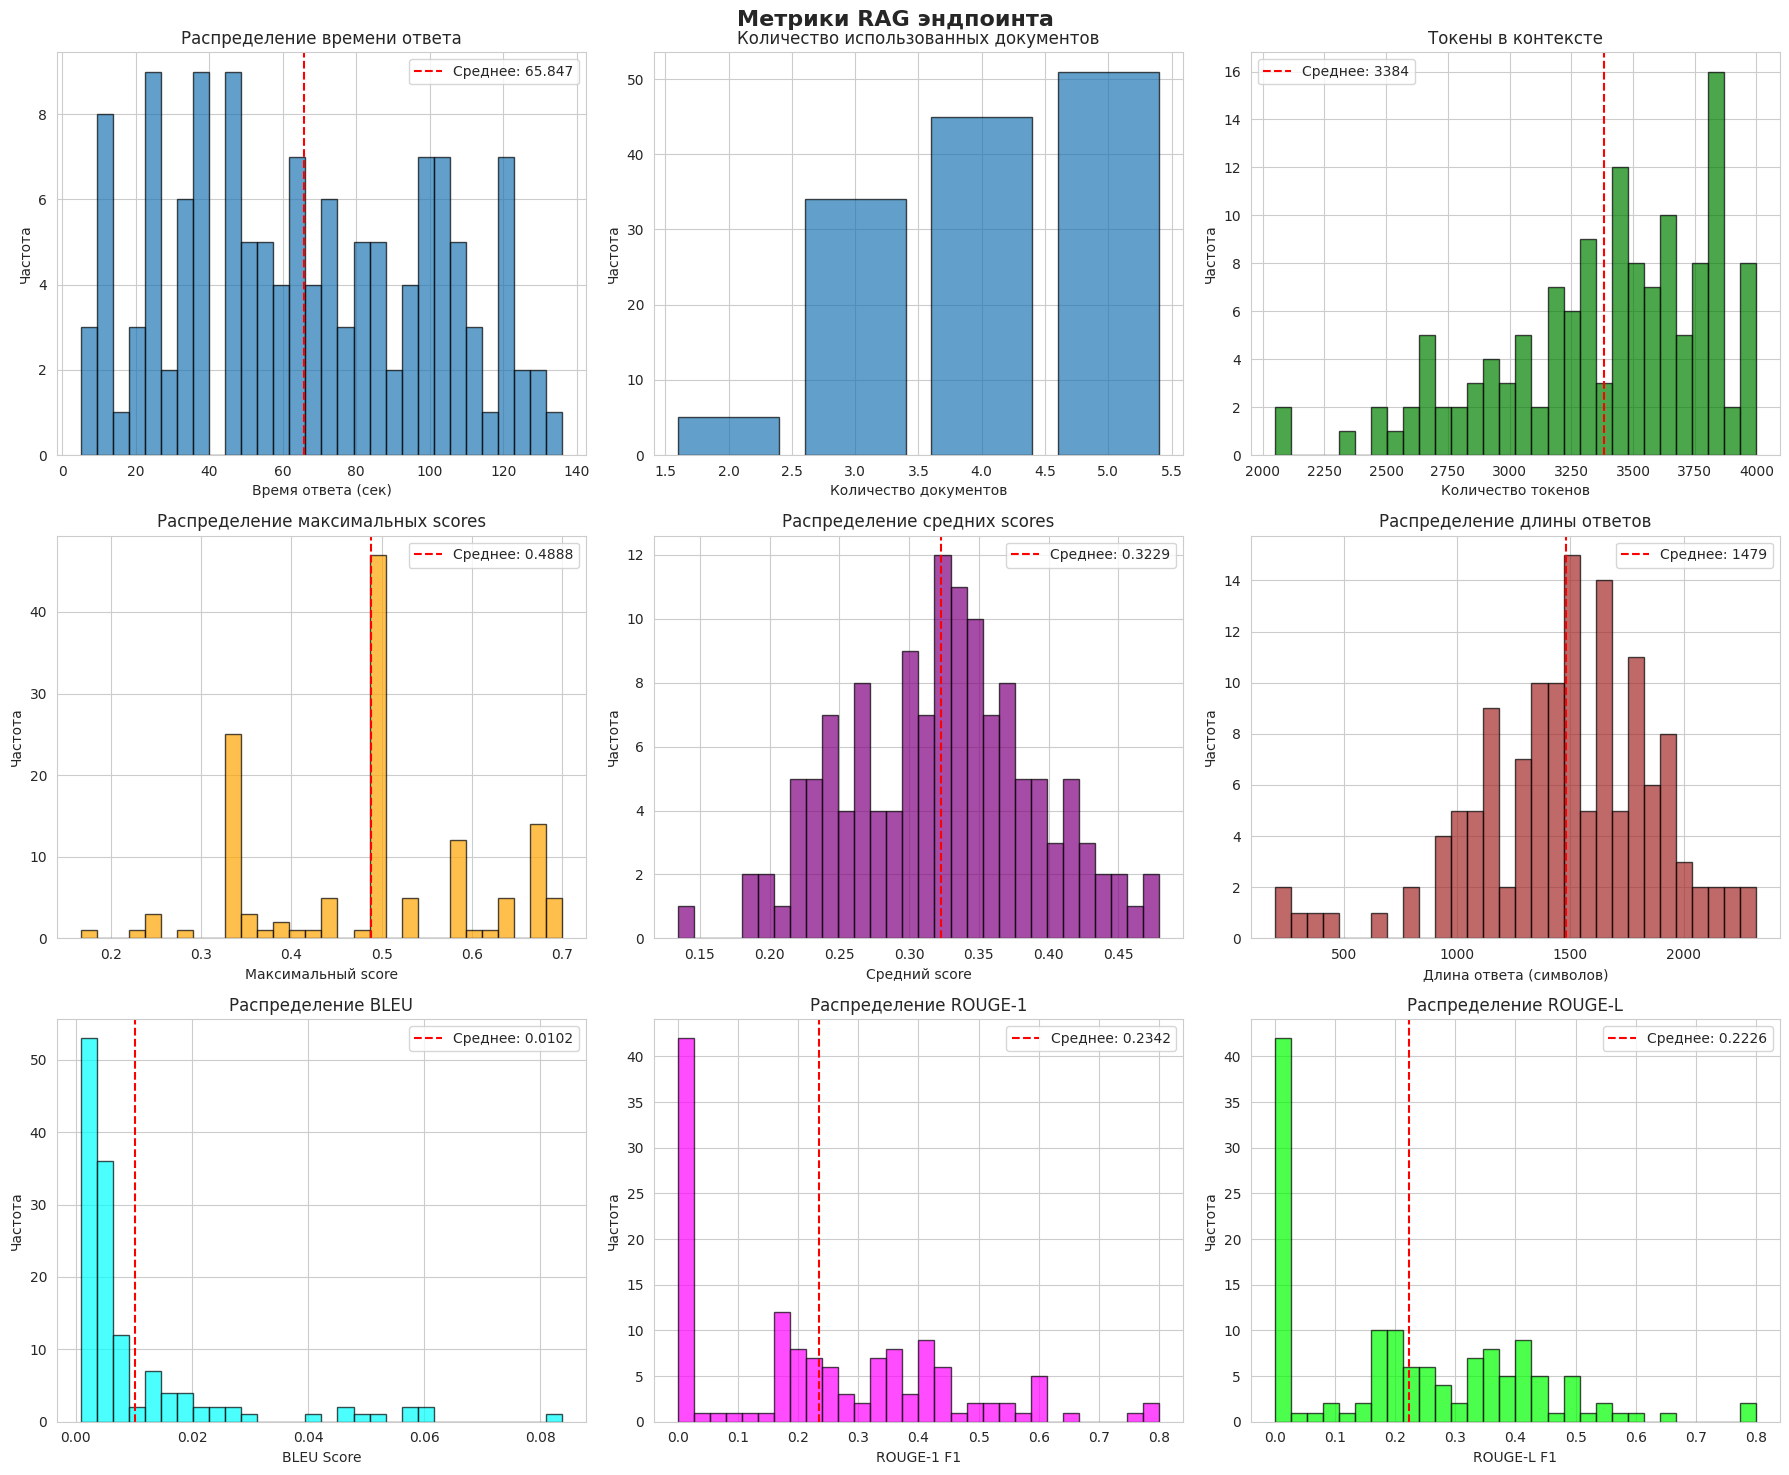

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Метрики RAG эндпоинта', fontsize=16, fontweight='bold')

# 1. Распределение времени ответа
axes[0, 0].hist(df['response_time'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Время ответа (сек)')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].set_title('Распределение времени ответа')
axes[0, 0].axvline(df['response_time'].mean(), color='red', linestyle='--', label=f'Среднее: {df["response_time"].mean():.3f}')
axes[0, 0].legend()

# 2. Распределение количества использованных документов
doc_counts = df['num_documents_used'].value_counts().sort_index()
axes[0, 1].bar(doc_counts.index, doc_counts.values, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Количество документов')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Количество использованных документов')

# 3. Распределение токенов в контексте
axes[0, 2].hist(df['total_tokens_context'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 2].set_xlabel('Количество токенов')
axes[0, 2].set_ylabel('Частота')
axes[0, 2].set_title('Токены в контексте')
axes[0, 2].axvline(df['total_tokens_context'].mean(), color='red', linestyle='--', label=f'Среднее: {df["total_tokens_context"].mean():.0f}')
axes[0, 2].legend()

# 4. Распределение максимальных scores
axes[1, 0].hist(df['max_score'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Максимальный score')
axes[1, 0].set_ylabel('Частота')
axes[1, 0].set_title('Распределение максимальных scores')
axes[1, 0].axvline(df['max_score'].mean(), color='red', linestyle='--', label=f'Среднее: {df["max_score"].mean():.4f}')
axes[1, 0].legend()

# 5. Распределение средних scores
axes[1, 1].hist(df['avg_score'], bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_xlabel('Средний score')
axes[1, 1].set_ylabel('Частота')
axes[1, 1].set_title('Распределение средних scores')
axes[1, 1].axvline(df['avg_score'].mean(), color='red', linestyle='--', label=f'Среднее: {df["avg_score"].mean():.4f}')
axes[1, 1].legend()

# 6. Распределение длины ответов
axes[1, 2].hist(df['answer_length'], bins=30, edgecolor='black', alpha=0.7, color='brown')
axes[1, 2].set_xlabel('Длина ответа (символов)')
axes[1, 2].set_ylabel('Частота')
axes[1, 2].set_title('Распределение длины ответов')
axes[1, 2].axvline(df['answer_length'].mean(), color='red', linestyle='--', label=f'Среднее: {df["answer_length"].mean():.0f}')
axes[1, 2].legend()

# 7. BLEU scores
axes[2, 0].hist(df['bleu'], bins=30, edgecolor='black', alpha=0.7, color='cyan')
axes[2, 0].set_xlabel('BLEU Score')
axes[2, 0].set_ylabel('Частота')
axes[2, 0].set_title('Распределение BLEU')
axes[2, 0].axvline(df['bleu'].mean(), color='red', linestyle='--', label=f'Среднее: {df["bleu"].mean():.4f}')
axes[2, 0].legend()

# 8. ROUGE-1 scores
axes[2, 1].hist(df['rouge1'], bins=30, edgecolor='black', alpha=0.7, color='magenta')
axes[2, 1].set_xlabel('ROUGE-1 F1')
axes[2, 1].set_ylabel('Частота')
axes[2, 1].set_title('Распределение ROUGE-1')
axes[2, 1].axvline(df['rouge1'].mean(), color='red', linestyle='--', label=f'Среднее: {df["rouge1"].mean():.4f}')
axes[2, 1].legend()

# 9. ROUGE-L scores
axes[2, 2].hist(df['rougeL'], bins=30, edgecolor='black', alpha=0.7, color='lime')
axes[2, 2].set_xlabel('ROUGE-L F1')
axes[2, 2].set_ylabel('Частота')
axes[2, 2].set_title('Распределение ROUGE-L')
axes[2, 2].axvline(df['rougeL'].mean(), color='red', linestyle='--', label=f'Среднее: {df["rougeL"].mean():.4f}')
axes[2, 2].legend()

plt.tight_layout()
plt.show()


## 9. Визуализация дополнительных метрик (Semantic Similarity, Faithfulness, Answer Relevance)


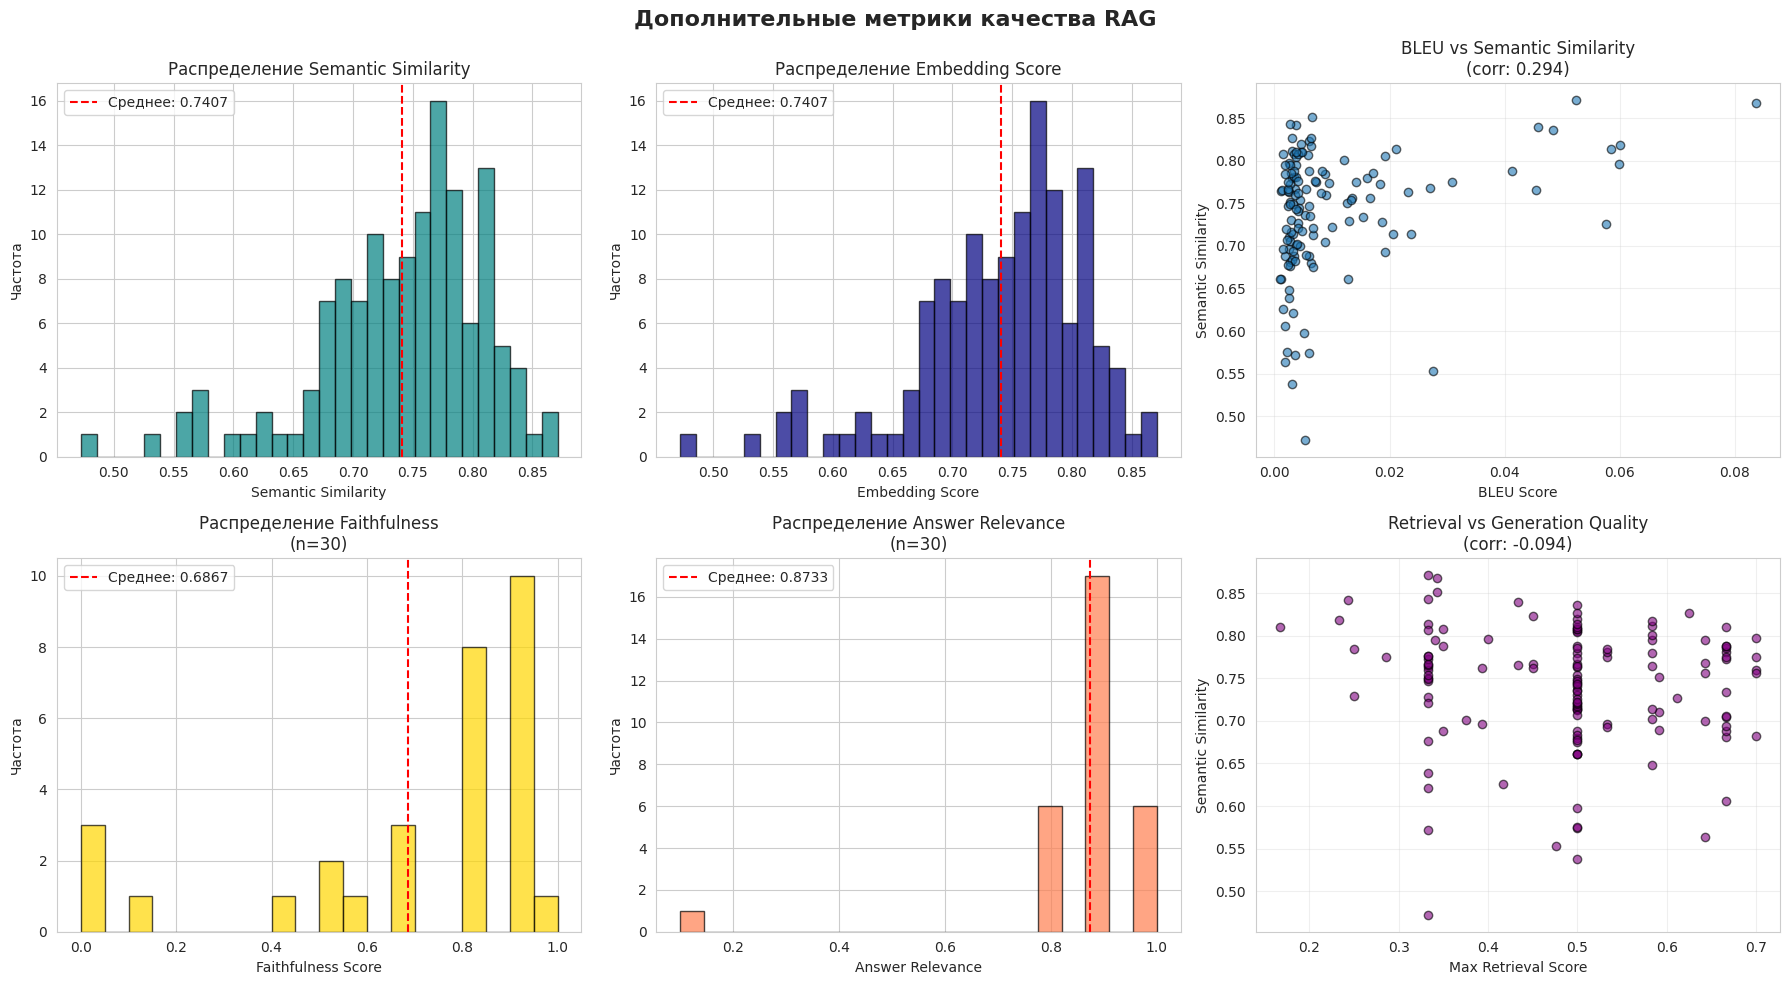

In [15]:
# Создаём дополнительные графики для новых метрик
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Дополнительные метрики качества RAG', fontsize=16, fontweight='bold')

# 1. Semantic Similarity
axes[0, 0].hist(df['semantic_similarity'], bins=30, edgecolor='black', alpha=0.7, color='teal')
axes[0, 0].set_xlabel('Semantic Similarity')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].set_title('Распределение Semantic Similarity')
axes[0, 0].axvline(df['semantic_similarity'].mean(), color='red', linestyle='--', 
                   label=f'Среднее: {df["semantic_similarity"].mean():.4f}')
axes[0, 0].legend()

# 2. Embedding Score (BERTScore-like)
axes[0, 1].hist(df['embedding_score'], bins=30, edgecolor='black', alpha=0.7, color='navy')
axes[0, 1].set_xlabel('Embedding Score')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение Embedding Score')
axes[0, 1].axvline(df['embedding_score'].mean(), color='red', linestyle='--', 
                   label=f'Среднее: {df["embedding_score"].mean():.4f}')
axes[0, 1].legend()

# 3. Сравнение BLEU vs Semantic Similarity
axes[0, 2].scatter(df['bleu'], df['semantic_similarity'], alpha=0.6, edgecolors='black')
axes[0, 2].set_xlabel('BLEU Score')
axes[0, 2].set_ylabel('Semantic Similarity')
axes[0, 2].set_title(f'BLEU vs Semantic Similarity\n(corr: {df["bleu"].corr(df["semantic_similarity"]):.3f})')
axes[0, 2].grid(True, alpha=0.3)

# 4. Faithfulness (если есть)
if 'faithfulness' in df.columns and df['faithfulness'].notna().sum() > 0:
    axes[1, 0].hist(df['faithfulness'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='gold')
    axes[1, 0].set_xlabel('Faithfulness Score')
    axes[1, 0].set_ylabel('Частота')
    axes[1, 0].set_title(f'Распределение Faithfulness\n(n={df["faithfulness"].notna().sum()})')
    axes[1, 0].axvline(df['faithfulness'].mean(), color='red', linestyle='--', 
                       label=f'Среднее: {df["faithfulness"].mean():.4f}')
    axes[1, 0].legend()
else:
    axes[1, 0].text(0.5, 0.5, 'Faithfulness\nне вычислен', 
                    ha='center', va='center', fontsize=14)
    axes[1, 0].set_xticks([])
    axes[1, 0].set_yticks([])

# 5. Answer Relevance (если есть)
if 'answer_relevance' in df.columns and df['answer_relevance'].notna().sum() > 0:
    axes[1, 1].hist(df['answer_relevance'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='coral')
    axes[1, 1].set_xlabel('Answer Relevance')
    axes[1, 1].set_ylabel('Частота')
    axes[1, 1].set_title(f'Распределение Answer Relevance\n(n={df["answer_relevance"].notna().sum()})')
    axes[1, 1].axvline(df['answer_relevance'].mean(), color='red', linestyle='--', 
                       label=f'Среднее: {df["answer_relevance"].mean():.4f}')
    axes[1, 1].legend()
else:
    axes[1, 1].text(0.5, 0.5, 'Answer Relevance\nне вычислен', 
                    ha='center', va='center', fontsize=14)
    axes[1, 1].set_xticks([])
    axes[1, 1].set_yticks([])

# 6. Semantic Similarity vs Max Score
axes[1, 2].scatter(df['max_score'], df['semantic_similarity'], alpha=0.6, edgecolors='black', color='purple')
axes[1, 2].set_xlabel('Max Retrieval Score')
axes[1, 2].set_ylabel('Semantic Similarity')
axes[1, 2].set_title(f'Retrieval vs Generation Quality\n(corr: {df["max_score"].corr(df["semantic_similarity"]):.3f})')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Корреляция метрик качества с другими параметрами


In [16]:
print("\n📊 Расширенные корреляции метрик качества:\n")
print("=== Базовые метрики ===")
print(f"  • BLEU ↔ Max Score: {df['bleu'].corr(df['max_score']):.4f}")
print(f"  • BLEU ↔ Avg Score: {df['bleu'].corr(df['avg_score']):.4f}")
print(f"  • BLEU ↔ Токены: {df['bleu'].corr(df['total_tokens_context']):.4f}")
print(f"  • ROUGE-1 ↔ Max Score: {df['rouge1'].corr(df['max_score']):.4f}")
print(f"  • ROUGE-1 ↔ Токены: {df['rouge1'].corr(df['total_tokens_context']):.4f}")
print(f"  • ROUGE-L ↔ Max Score: {df['rougeL'].corr(df['max_score']):.4f}")
print(f"  • BLEU ↔ ROUGE-1: {df['bleu'].corr(df['rouge1']):.4f}")
print(f"  • BLEU ↔ ROUGE-L: {df['bleu'].corr(df['rougeL']):.4f}")

print("\n=== Новые метрики ===")
print(f"  • Semantic Similarity ↔ Max Score: {df['semantic_similarity'].corr(df['max_score']):.4f}")
print(f"  • Semantic Similarity ↔ BLEU: {df['semantic_similarity'].corr(df['bleu']):.4f}")
print(f"  • Semantic Similarity ↔ ROUGE-1: {df['semantic_similarity'].corr(df['rouge1']):.4f}")
print(f"  • Embedding Score ↔ Max Score: {df['embedding_score'].corr(df['max_score']):.4f}")
print(f"  • Embedding Score ↔ BLEU: {df['embedding_score'].corr(df['bleu']):.4f}")
print(f"  • Embedding Score ↔ Токены: {df['embedding_score'].corr(df['total_tokens_context']):.4f}")

if 'faithfulness' in df.columns and df['faithfulness'].notna().sum() > 5:
    print("\n=== Faithfulness корреляции ===")
    print(f"  • Faithfulness ↔ Max Score: {df['faithfulness'].corr(df['max_score']):.4f}")
    print(f"  • Faithfulness ↔ Semantic Similarity: {df['faithfulness'].corr(df['semantic_similarity']):.4f}")
    print(f"  • Faithfulness ↔ BLEU: {df['faithfulness'].corr(df['bleu']):.4f}")

if 'answer_relevance' in df.columns and df['answer_relevance'].notna().sum() > 5:
    print("\n=== Answer Relevance корреляции ===")
    print(f"  • Answer Relevance ↔ Semantic Similarity: {df['answer_relevance'].corr(df['semantic_similarity']):.4f}")
    print(f"  • Answer Relevance ↔ ROUGE-1: {df['answer_relevance'].corr(df['rouge1']):.4f}")
    if 'faithfulness' in df.columns:
        print(f"  • Answer Relevance ↔ Faithfulness: {df['answer_relevance'].corr(df['faithfulness']):.4f}")



📊 Расширенные корреляции метрик качества:

=== Базовые метрики ===
  • BLEU ↔ Max Score: -0.1307
  • BLEU ↔ Avg Score: -0.1357
  • BLEU ↔ Токены: -0.0957
  • ROUGE-1 ↔ Max Score: 0.0682
  • ROUGE-1 ↔ Токены: -0.0871
  • ROUGE-L ↔ Max Score: 0.0584
  • BLEU ↔ ROUGE-1: -0.1012
  • BLEU ↔ ROUGE-L: -0.1068

=== Новые метрики ===
  • Semantic Similarity ↔ Max Score: -0.0939
  • Semantic Similarity ↔ BLEU: 0.2945
  • Semantic Similarity ↔ ROUGE-1: 0.1216
  • Embedding Score ↔ Max Score: -0.0939
  • Embedding Score ↔ BLEU: 0.2945
  • Embedding Score ↔ Токены: -0.0627

=== Faithfulness корреляции ===
  • Faithfulness ↔ Max Score: 0.4480
  • Faithfulness ↔ Semantic Similarity: 0.2418
  • Faithfulness ↔ BLEU: -0.3680

=== Answer Relevance корреляции ===
  • Answer Relevance ↔ Semantic Similarity: 0.7148
  • Answer Relevance ↔ ROUGE-1: 0.2606
  • Answer Relevance ↔ Faithfulness: 0.4346


## 11. Сохранение обновлённых результатов


In [17]:
# Сохраняем обновлённые результаты с новыми метриками в CSV
output_path = '/home/llm-dev/project/lifelong_learning_assistant/rag/notebook/rag_evaluation_results_extended.csv'

# Создаём упрощённую версию без вложенных структур
df_to_save = df.drop(columns=['documents', 'sources'])
df_to_save.to_csv(output_path, index=False, encoding='utf-8')

print(f"✅ Обновлённые результаты сохранены в: {output_path}")
print(f"   Размер файла: {len(df_to_save)} строк, {len(df_to_save.columns)} колонок")
print(f"\n📊 Сохранённые метрики:")
print(f"   • Базовые: BLEU, ROUGE-1, ROUGE-2, ROUGE-L")
print(f"   • Новые: Semantic Similarity, Embedding Score")
if 'faithfulness' in df.columns:
    print(f"   • LLM-based: Faithfulness, Answer Relevance")
    
print(f"\n💡 Для полного анализа используйте:")
print(f"   df = pd.read_csv('{output_path}')")


✅ Обновлённые результаты сохранены в: /home/llm-dev/project/lifelong_learning_assistant/rag/notebook/rag_evaluation_results_extended.csv
   Размер файла: 135 строк, 22 колонок

📊 Сохранённые метрики:
   • Базовые: BLEU, ROUGE-1, ROUGE-2, ROUGE-L
   • Новые: Semantic Similarity, Embedding Score
   • LLM-based: Faithfulness, Answer Relevance

💡 Для полного анализа используйте:
   df = pd.read_csv('/home/llm-dev/project/lifelong_learning_assistant/rag/notebook/rag_evaluation_results_extended.csv')


## 📋 Резюме добавленных метрик

### ✅ Что было добавлено:

**1. Semantic Similarity (через OpenAI Embeddings)**
- Использует тот же эмбеддинг-модель, что и RAG система
- Вычисляет косинусное сходство между ожидаемым и сгенерированным ответом
- Более точная оценка семантической близости, чем BLEU/ROUGE
- **Преимущество**: Учитывает смысл, а не только совпадение слов

**2. Embedding Score (BERTScore-подобная метрика)**
- Аналог BERTScore, но через OpenAI embeddings
- Оценивает качество генерации на уровне семантики
- **Преимущество**: Не требует установки дополнительных моделей

**3. Faithfulness Score (на подвыборке)**
- Проверяет, не галлюцинирует ли модель
- Оценивает, основан ли ответ только на предоставленном контексте
- Использует LLM для оценки (GPT-4o-mini)
- **Критично для RAG**: Главная метрика надёжности системы

**4. Answer Relevance (на подвыборке)**
- Оценивает, насколько ответ релевантен вопросу
- Использует LLM для оценки
- **Преимущество**: Оценивает полноту и точность ответа

### 📊 Рекомендации по интерпретации:

**Semantic Similarity > 0.85**: Отличное семантическое соответствие
**Semantic Similarity 0.70-0.85**: Хорошее соответствие
**Semantic Similarity < 0.70**: Требует проверки

**Faithfulness > 0.8**: Ответ полностью основан на контексте
**Faithfulness 0.6-0.8**: Есть небольшие обобщения
**Faithfulness < 0.6**: Возможны галлюцинации

**Answer Relevance > 0.8**: Ответ полностью релевантен вопросу
**Answer Relevance 0.6-0.8**: Частично релевантен
**Answer Relevance < 0.6**: Слабая релевантность

### 🔍 Следующие шаги:

1. Запустите ячейки с новыми метриками (Cell 15, 17, 19)
2. Проанализируйте корреляции между метриками
3. Идентифицируйте вопросы с низкими метриками качества
4. Оптимизируйте RAG систему на основе insights
